# Imports & Loading

In [1]:
import sys
sys.path.append('../')
import build_dataset

lfx = build_dataset.load_functions()
pfx = build_dataset.performance_functions()

pp = build_dataset.dataset_preprocess(local_activity_store='gc_activitydata_local.csv'
                                    ,local_activity_model_params='modeled_ef.csv')
lfx.metric_function_map

Local dataset available. process using `dataset_preprocess`


{'Daily_TSS': <bound method load_functions.daily_tss of <build_dataset.load_functions object at 0x7fe592f2f370>>,
 'TIZ2_5': <bound method load_functions.tiz2of5 of <build_dataset.load_functions object at 0x7fe592f2f370>>,
 'TIZ1_3': <bound method load_functions.tiz1of3 of <build_dataset.load_functions object at 0x7fe592f2f370>>,
 'TIZ2_3': <bound method load_functions.tiz2of3 of <build_dataset.load_functions object at 0x7fe592f2f370>>,
 'TIZ3_3': <bound method load_functions.tiz3of3 of <build_dataset.load_functions object at 0x7fe592f2f370>>}

In [2]:
pfx.metric_function_map

{'VO2': <bound method performance_functions.calc_vo2 of <build_dataset.performance_functions object at 0x7fe5930b3430>>,
 'Garmin VO2': <bound method performance_functions.use_garmin_vo2 of <build_dataset.performance_functions object at 0x7fe5930b3430>>,
 'AE EF': <bound method performance_functions.calc_ae_ef of <build_dataset.performance_functions object at 0x7fe5930b3430>>,
 'Power Index': <bound method performance_functions.use_power_index of <build_dataset.performance_functions object at 0x7fe5930b3430>>,
 'Power Index EF': <bound method performance_functions.use_power_index_ef of <build_dataset.performance_functions object at 0x7fe5930b3430>>,
 'Mod AE Power': <bound method performance_functions.modeled_aerobic_threshold_power of <build_dataset.performance_functions object at 0x7fe5930b3430>>}

In [3]:
loaded_df = lfx.derive_load(frame=pp.activity_data, load_metric='TIZ1_3')
loaded_df = lfx.derive_load(frame=pp.activity_data, load_metric='TIZ2_3')
loaded_df = lfx.derive_load(frame=pp.activity_data, load_metric='TIZ3_3')
loaded_df = loaded_df[loaded_df['TIZ1_3'].cumsum() > 0].copy()

In [5]:
pfx.derive_performance(loaded_df, performance_metric='VO2')

,date,time,filename,Power_Index,Duration,Athlete_Weight,Average_Power,Average_Heart_Rate,Max_Heartrate,IsoPower,...,Shoes,Workout_Code,Workout_Title,Indoor,Frame,Sport,TIZ1_3,TIZ2_3,TIZ3_3,VO2
493,2019-07-15,19:00:00,2019_07_15_19_00_00.json,59.5380,2015,87.320,159.9330,129.5160,170.0,196.2460,...,NaN,AE,Easy,1.0,Equinox Stages Bike,Bike,1552,223,240,41.194513
494,2019-07-16,07:40:22,2019_07_16_07_40_22.json,0.0000,4623,87.320,0.0000,157.4370,171.0,0.0000,...,NaN,AE,Long,1.0,NaN,Other,0,0,0,0.000000
495,2019-07-17,06:19:04,2019_07_17_06_19_04.json,64.6141,2761,87.630,172.2460,136.5370,174.0,206.9030,...,NaN,T,FTP,1.0,Equinox Stages Bike,Bike,1687,594,480,40.993804
496,2019-07-18,08:06:42,2019_07_18_08_06_42.json,0.0000,1937,87.630,0.0000,92.1838,131.0,0.0000,...,NaN,MF,NaN,1.0,NaN,Other,0,0,0,0.000000
497,2019-07-18,08:38:59,2019_07_18_08_38_59.json,0.0000,1996,87.630,0.0000,74.5794,93.0,0.0000,...,NaN,MF,NaN,1.0,NaN,Other,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876,2023-01-27,16:56:28,2023_01_27_16_56_28.json,68.9178,5587,84.176,181.7810,118.2550,134.0,190.1410,...,NaN,AE,Easy,1.0,Canyon Ultimate,Bike,5320,216,51,55.560199
1877,2023-01-28,07:41:36,2023_01_28_07_41_36.json,59.6866,8224,85.808,156.9050,128.4070,177.0,231.4200,...,NaN,AE,Long,0.0,Canyon Ultimate,Bike,6389,622,1364,41.642619
1878,2023-01-28,10:12:44,2023_01_28_10_12_44.json,17.7570,151,85.808,62.5861,98.3700,115.0,92.9694,...,NaN,Rec,Coffee,0.0,Canyon Ultimate,Bike,6389,622,1364,25.157999
1879,2023-01-30,17:53:04,2023_01_30_17_53_04.json,71.7519,3624,84.141,190.3260,122.9250,167.0,232.7520,...,NaN,T,FTP,1.0,Canyon Ultimate,Bike,2749,90,785,54.918751


# Data Processing

In [59]:
# data = data_original[data_original['Sport'] == 'Bike'].copy()
# data['mod_pow_at_threshold'] = data['a'] + data['b'] * athlete_statics['threshold_hr'] +  data['c']*(60*60)*20

# data = data.groupby('date').agg({'L1_Time_in_Zone':'sum'
#                                 ,'L2_Time_in_Zone':'sum'
#                                 ,'L3_Time_in_Zone':'sum'
#                                 ,'L4_Time_in_Zone':'sum'
#                                 ,'L5_Time_in_Zone':'sum'
#                                 ,'L6_Time_in_Zone':'sum'
#                                 ,'L7_Time_in_Zone':'sum'
#                                 ,'mod_pow_at_threshold':'max'}).reset_index()

# # data['date'] = data.index
# data['date'] = pd.to_datetime(data['date'])
# data = data.sort_values(by=['date'])
# data.index = pd.DatetimeIndex(data['date'])
# missing_dates = pd.date_range(start=data.index.min(), end=data.index.max())
# data = data.reindex(missing_dates, fill_value=0)
# data['mod_pow_at_threshold'] = data['mod_pow_at_threshold'].replace(0,np.nan)
# data['mod_pow_at_threshold'] = data['mod_pow_at_threshold'].fillna(method='ffill')
# data = data.dropna()

### Run Bout Fork

In [70]:
from sklearn.linear_model import LinearRegression
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

<AxesSubplot:xlabel='date'>

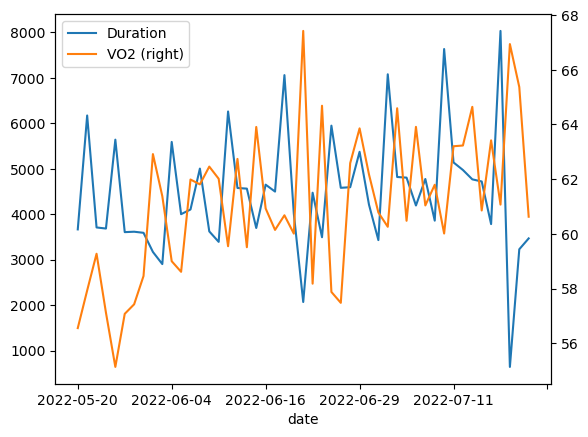

In [85]:
check = loaded_df[(loaded_df['Sport']=='Run') & (loaded_df['date'] > '2022-05-19') & (loaded_df['date'] <= '2022-07-22')]
check.groupby('date').agg({'Duration':'sum','VO2':'mean'}).plot(secondary_y='VO2')

In [82]:
X, y = check[['Duration','TIZ1_3','TIZ2_3','TIZ3_3']][1:], check['VO2'][:-1]

In [83]:
model = LinearRegression(fit_intercept=True)
model.fit(X.to_numpy(), y.to_numpy().reshape(-1,1))
y_hat = model.predict(X.to_numpy())

Text(56, 58, 'RMSE: 2.64')

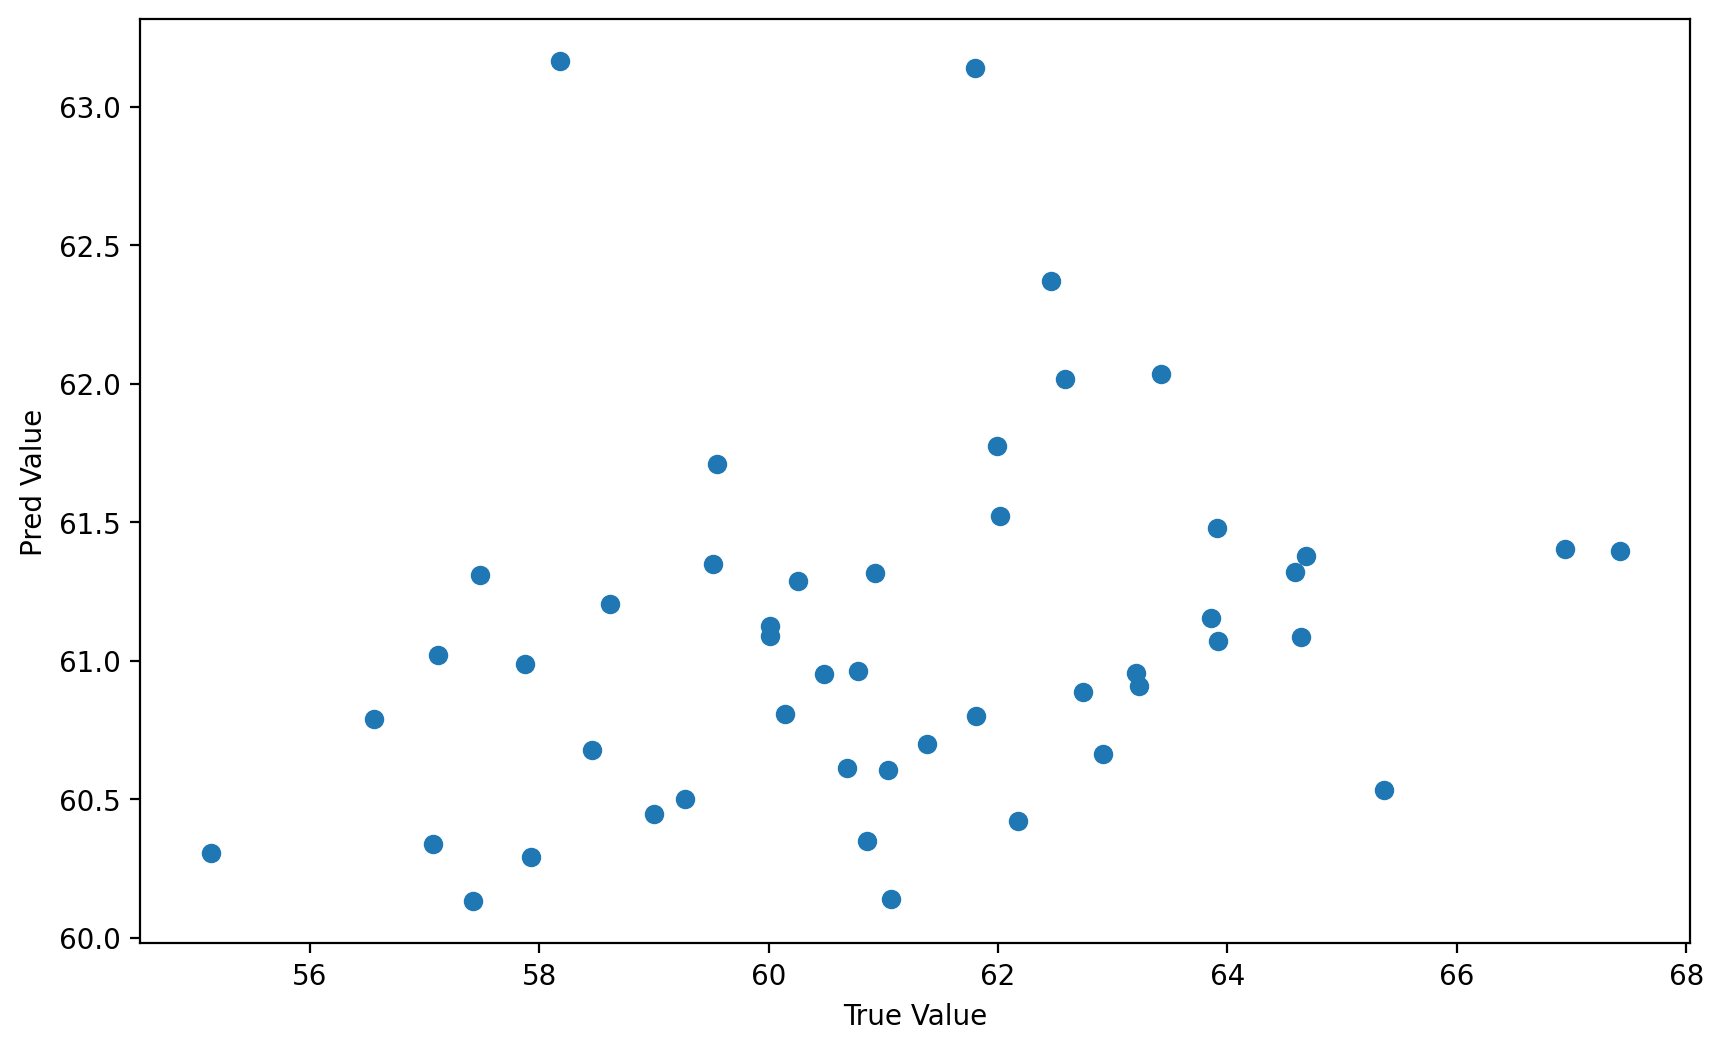

In [84]:
fig, ax = plt.subplots(1,1, figsize=(10,6), dpi=200)
ax.scatter(y, y_hat, label='True vs. Pred')
ax.set_xlabel('True Value')
ax.set_ylabel('Pred Value')

rmse = np.sqrt(((y.to_numpy().reshape(-1,1) - y_hat)**2).mean())

ax.annotate(f'RMSE: {rmse:0.2f}', xy=(56,58))

# Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

## CNN

In [ ]:
class TimeSeriesCNN(nn.Module):
    def __init__(self):
        super(TimeSeriesCNN, self).__init__()
        
        # Define the layers of the CNN
        self.conv1 = nn.Conv1d(in_channels=8, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.fc1 = nn.Linear(in_features=64*8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=2)

    def forward(self, x):
        # Pass the input through the layers of the CNN
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = x.view(-1, 64*8)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
sl_df = loaded_df[loaded_df['Sport'].isin(['Bike','Run'])][['date','Sport','TIZ1_3','TIZ2_3','TIZ3_3','VO2']].groupby(['date','Sport']).agg({'TIZ1_3':'sum','TIZ2_3':'sum','TIZ3_3':'sum','VO2':'max'})
ul_df = sl_df.unstack(level=1).copy()
ul_df.fillna({'TIZ1_3':0
             ,'TIZ2_3':0
             ,'TIZ3_3':0
            }).fillna(method='ffill', limit=5, inplace=True)

In [ ]:
comp_vo2 = ul_df[ul_df['VO2'].isnull().sum(axis=1) < 1]['VO2']
bike_to_run = (comp_vo2['Bike'] / comp_vo2['Run']).mean()
comp_vo2['Run from bike'] = comp_vo2['Bike'] * 1/bike_to_run
ax = comp_vo2.plot(kind='scatter', x = 'Run', y='Run from bike', xlim=(50,75), ylim=(50,75), figsize=(4,4))
sing_vo2 = ul_df[ul_df['VO2'].isnull().sum(axis=1) < 2]['VO2']
ul_df[('VO2','Run')].fillna(ul_df[('VO2','Bike')] * 1/bike_to_run, inplace=True)
ul_df[('VO2','Bike')].fillna(ul_df[('VO2','Run')] * bike_to_run, inplace=True)

In [ ]:
fl_df = ul_df[['TIZ1_3','TIZ2_3','TIZ3_3']]
fl_df = fl_df.join(ul_df[['VO2']])
fl_df[[('VO2_l1','Bike'),('VO2_l1','Run')]] = fl_df['VO2'].shift(-1)

In [ ]:
input_data = fl_df[['TIZ1_3','TIZ2_3','TIZ3_3','VO2_l1']].to_numpy()[:-1]
target_data = fl_df['VO2'][:-1].to_numpy()

In [ ]:
test_percent = 0.8
test_split = int(input_data.shape[0] * test_percent)
train_input_data, train_target_data = input_data[:test_split], target_data[:test_split]
test_input_data, test_target_data = input_data[test_split:], target_data[test_split:]

In [ ]:
train_input_data.shape

In [ ]:
train_input_data[:32].T.shape

In [ ]:
model = TimeSeriesCNN()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    inputs = torch.from_numpy(train_input_data[:32].T).float()
    targets = torch.from_numpy(train_target_data).float()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    # Evaluate the model on the test set
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            inputs = torch.from_numpy(test_data).float()
            targets = torch.from_numpy(test_labels).float()
            outputs = model(inputs)
            test_loss = criterion(outputs, targets)
            print(f"Epoch {epoch}: Test loss = {test_loss.item()}")

In [ ]:
def generator(data, min_index=0, max_index=None, batch_size=16, n_steps=150, step_length=1000):
    if max_index is None:
        max_index = len(data) - 1
     
    while True:
        # Pick indices of ending positions
        rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
         
        # Initialize feature matrices and targets
        samples = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            targets[j] = data[row - 1, 1]
        yield samples, targets

## RNN

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
# Shaping of input data
data = np.random.rand(1000, 50, 10)
labels = np.random.rand(1000, 1)
input_data = np.random.rand(1000, 50, 10)
labels = np.random.rand(1000, 1)

# Split the data into training and test sets
train_data, train_labels = data[:800], labels[:800]
test_data, test_labels = data[800:], labels[800:]

# Initialize the model
input_size = 10
hidden_size = 64
output_size = 1
model = RNN(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    inputs = torch.from_numpy(train_data).float()
    targets = torch.from_numpy(train_labels).float()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    # Evaluate the model on the test set
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            inputs = torch.from_numpy(test_data).float()
            targets = torch.from_numpy(test_labels).float()
            outputs = model(inputs)
            test_loss = criterion(outputs, targets)
            print(f"Epoch {epoch}: Test loss = {test_loss.item()}")